# AMLB shorter runs visualizations

In [1]:
import itertools
import math
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn

In [2]:
from data_processing import get_print_friendly_name, impute_missing_results, calculate_ranks, add_rescale, is_old
from visualization_early import FRAMEWORK_TO_COLOR

In [3]:
PROJECT_ROOT = Path(".").absolute().parent
DATA_DIRECTORY = PROJECT_ROOT / "data"
FIGURE_DIRECTORY = PROJECT_ROOT / "figures"

for subfolder in ["pareto_performance_inference", "pareto_performance_training", "pareto_training_inference"]:
    (FIGURE_DIRECTORY / subfolder).mkdir(parents=True, exist_ok=True)

In [4]:
results_not_early = pd.read_csv(DATA_DIRECTORY / "amlb_all.csv", dtype={"info": str})

In [5]:
results_llm = pd.read_csv(DATA_DIRECTORY / "LLM_amlb_all.csv", dtype={"info": str})
results_llm['constraint'] = results_llm['constraint'].str.replace('8c_gp3', '')
results_llm['framework'] = results_llm['framework'] + '_' + results_llm['constraint']
results_llm['constraint'] = 'Mixed Time Constraints'
results = pd.concat([results_not_early, results_llm])

In [6]:
results["framework"] = results["framework"].apply(get_print_friendly_name)
print(results.framework.unique())

['AutoGluon(HQIL)_10min' 'AutoGluon(HQIL)_30min' 'AutoGluon(HQIL)_5min'
 'AutoGluon(HQIL)_60min' 'AutoGluon(HQ)_10min' 'AutoGluon(HQ)_30min'
 'AutoGluon(HQ)_5min' 'AutoGluon(HQ)_60min' 'AutoGluon(B)_10min'
 'AutoGluon(B)_30min' 'AutoGluon(B)_5min' 'AutoGluon(B)_60min'
 'FEDOT_10min' 'FEDOT_30min' 'FEDOT_5min' 'FEDOT_60min' 'GAMA(B)_10min'
 'GAMA(B)_30min' 'GAMA(B)_5min' 'GAMA(B)_60min' 'H2OAutoML_10min'
 'H2OAutoML_30min' 'H2OAutoML_5min' 'H2OAutoML_60min' 'NaiveAutoML_10min'
 'NaiveAutoML_30min' 'NaiveAutoML_5min' 'NaiveAutoML_60min' 'RF_10min'
 'RF_30min' 'RF_5min' 'RF_60min' 'TPOT_10min' 'TPOT_30min' 'TPOT_5min'
 'TPOT_60min' 'TRF_10min' 'TRF_30min' 'TRF_5min' 'TRF_60min'
 'autosklearn2_10min' 'autosklearn2_30min' 'autosklearn2_5min'
 'autosklearn2_60min' 'autosklearn_10min' 'autosklearn_30min'
 'autosklearn_5min' 'autosklearn_60min' 'CP_10min' 'CP_30min' 'CP_5min'
 'CP_60min' 'flaml_10min' 'flaml_30min' 'flaml_5min' 'flaml_60min'
 'lightautoml_10min' 'lightautoml_30min' 'lightautom

# Inference vs Performance

mean rescaled result vs median inference speed row/s at 10k and at 1

In [7]:
import matplotlib.text as mtext
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import MinMaxScaler
    
def calculate_pareto(xs, ys) -> list[tuple[float, float]]:
    pairs = list(zip(xs, ys))
    return [
        (x, y)
        for x, y in pairs
        if not any((x2>=x and y2 >=y) and (x!=x2 or y!=y2) for x2, y2 in pairs)
    ]

def plot_pareto(data, x, y, ax, color="#cccccc"):
    pareto = sorted(calculate_pareto(data[x], data[y]))
    for opt, next_opt in zip(pareto, pareto[1:]):
        ax.plot([opt[0], opt[0], next_opt[0]], [opt[1],next_opt[1], next_opt[1]], color=color, zorder=0)
        

In [8]:
# Define a function to replace the prefix
def replace_prefix(framework, prefix):
    if framework.startswith(prefix):
        return framework[len(prefix):]
    return framework

In [9]:
name_mapping = {
    'constantpredictor_60min': 'CP_60min',
    'RandomForest_60min': 'RF_60min',
    'TunedRandomForest_60min': 'TRF_60min'
}

In [10]:
list_order = list(FRAMEWORK_TO_COLOR.keys())

In [11]:
strings_by_time = ['_5min',]
extra_frameworks = ['RF_60min', 'TRF_60min', 'CP_60min']

### All frameworks by time

#### pareto_performance_inference


this frameworks ['AutoGluon(HQIL)_5min' 'AutoGluon(HQ)_5min' 'AutoGluon(B)_5min'
 'FEDOT_5min' 'GAMA(B)_5min' 'H2OAutoML_5min' 'NaiveAutoML_5min' 'RF_5min'
 'RF_60min' 'TPOT_5min' 'TRF_5min' 'TRF_60min' 'autosklearn2_5min'
 'autosklearn_5min' 'CP_5min' 'CP_60min' 'flaml_5min' 'lightautoml_5min'
 'MLJAR(B)_5min' 'GeneticLLM_5min']


C:\Users\20210595\AppData\Local\Temp\ipykernel_34800\2560390177.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_framework['framework'] = this_framework['framework'].apply(lambda x: name_mapping.get(x, x))


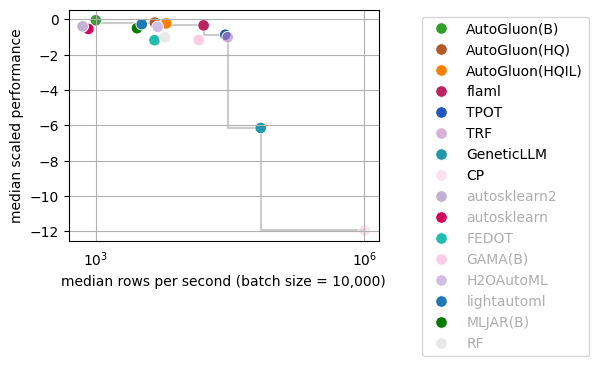

In [12]:
for name_time in strings_by_time:
    this_framework = results[results['framework'].str.contains(name_time) | results['framework'].isin(extra_frameworks)]
    print("this frameworks", this_framework.framework.unique())
    this_framework['framework'] = this_framework['framework'].apply(lambda x: name_mapping.get(x, x))
    this_framework = this_framework[~this_framework['framework'].str.contains('Naive')]
    exclude = ["CP_60min", "RF_60min", "TRF_60min"]
    data = this_framework
    data = impute_missing_results(data, with_results_from="CP_60min")
    
    data = data[["framework", "task", "constraint", "result", "infer_batch_size_file_10000",  "metric"]].groupby(["framework", "task", "constraint", "metric"], as_index=False).mean()
    data = add_rescale(data, lower="RF_60min")    
    data = data[~data["framework"].isin(exclude)]
    data['framework'] = data['framework'].str.replace(name_time, '')

    current_frameworks = data.framework.unique()
    common_elements = [element for element in list_order if element in current_frameworks]
    
    data["scaled"] = -data["scaled"]
    data = data.groupby(["framework", "constraint"])[["infer_batch_size_file_10000", "scaled"]].median()

    data["row_per_s"] = 10_000. / data["infer_batch_size_file_10000"]
    color_map = {k: v for k, v in FRAMEWORK_TO_COLOR.items() if k not in exclude}

    ###
    frameworks_to_keep_legend = []
    pareto_efficient = calculate_pareto(data["row_per_s"], data["scaled"])
    pareto_efficient_list = [x for x, y in pareto_efficient]
    pareto_not_efficient_list = []
    for framework in FRAMEWORK_TO_COLOR.keys():
        if framework in data.index.get_level_values('framework').unique():
            is_efficient = any(row_per_s_value in pareto_efficient_list for row_per_s_value in data.loc[framework, "row_per_s"])
            if is_efficient:
                frameworks_to_keep_legend.append(framework)
            else:
                pareto_not_efficient_list.append(framework)  # Grey color for inefficient methods

    # Create a dictionary to map frameworks to their corresponding row_per_s values
    framework_to_row_per_s = {framework: data.loc[framework, "row_per_s"].values[0] for framework in frameworks_to_keep_legend}
    
    # Sort frameworks_to_keep_legend based on the row_per_s values
    frameworks_to_keep_legend.sort(key=lambda framework: framework_to_row_per_s[framework])
    common_elements = frameworks_to_keep_legend + pareto_not_efficient_list# sorted
    ###
    
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax = seaborn.scatterplot(
        data, 
        x="row_per_s", 
        y="scaled", 
        hue="framework",
        palette=color_map,
        s=70,  # marker size
        hue_order=common_elements,
        ax=ax,
    )

    plot_pareto(data, x="row_per_s", y="scaled", ax=ax)
    
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.set_xscale('log')
    ax.set_xlabel('median rows per second (batch size = 10,000)')
    ax.set_ylabel('median scaled performance')
    ax.grid(True)  # Add grid here
    
    pareto_efficient = calculate_pareto(data["row_per_s"], data["scaled"])
    pareto_efficient_list = [x for x, y in pareto_efficient]
    pareto_efficient_list = sorted([x for x, y in pareto_efficient])
    first_last_pareto = [pareto_efficient_list[0], pareto_efficient_list[-1]]
    selected_ticks = first_last_pareto
    selected_labels = first_last_pareto
    selected_labels = [f"$10^{{{int(np.log10(tick))}}}$" for tick in selected_ticks]
    
    # Set the selected x-ticks and labels
    ax.set_xticks(selected_ticks)
    ax.set_xticklabels(selected_labels)
    
    # Ensure the tick parameters are set correctly
    ax.tick_params(axis='x', which='major', bottom=False, top=False, labelbottom=True)
    ###
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.7, 1))
    
    # Change the color of the first three labels to red
    for text in legend.get_texts()[len(frameworks_to_keep_legend):]:
        text.set_color('#aeaeae')
    ###
    with PdfPages(FIGURE_DIRECTORY / "pareto_performance_inference" / f"performance_inference{name_time}_all.pdf") as f:
        f.savefig(fig, bbox_inches="tight")

    # Define the file path for the PNG file
    file_path = FIGURE_DIRECTORY / "pareto_performance_inference" / f"performance_inference{name_time}_all.png"
    # Save the figure as a PNG file
    fig.savefig(file_path, bbox_inches="tight", dpi=1000)
    
    plt.show()
    plt.close(fig)

#### pareto_performance_training

C:\Users\20210595\AppData\Local\Temp\ipykernel_34800\3336151781.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_framework['framework'] = this_framework['framework'].apply(lambda x: name_mapping.get(x, x))


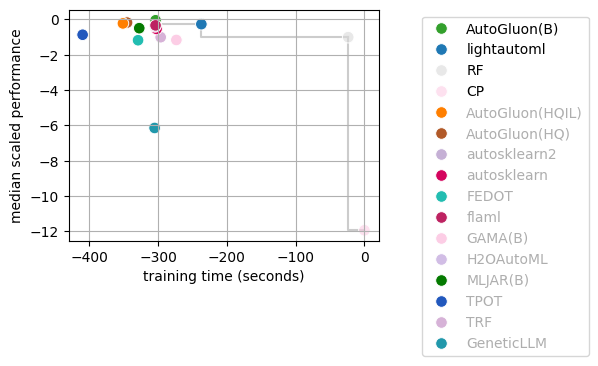

In [13]:
# pyplot.locator_params(nbins=4)
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MaxNLocator

for name_time in strings_by_time:
    this_framework = results[results['framework'].str.contains(name_time) | results['framework'].isin(extra_frameworks)]
    this_framework['framework'] = this_framework['framework'].apply(lambda x: name_mapping.get(x, x))
    this_framework = this_framework[~this_framework['framework'].str.contains('Naive')]
    
    exclude = ["CP_60min", "RF_60min", "TRF_60min"]
    data = this_framework
    data = impute_missing_results(data, with_results_from="CP_60min")
    
    data = data[["framework", "task", "constraint", "result", "training_duration",  "metric"]].groupby(["framework", "task", "constraint",  "metric"], as_index=False).mean()
    data = add_rescale(data, lower="RF_60min")    
    data = data[~data["framework"].isin(exclude)]
    data['framework'] = data['framework'].str.replace(name_time, '')
    data["scaled"] = -data["scaled"]
    data["training_duration"] = -data["training_duration"]

    current_frameworks = data.framework.unique()
    common_elements = [element for element in list_order if element in current_frameworks]
    data = data.groupby(["framework", "constraint"])[["training_duration", "scaled"]].median()
    color_map = {k: v for k, v in FRAMEWORK_TO_COLOR.items() if k not in exclude}

    ###
    frameworks_to_keep_legend = []
    pareto_efficient = calculate_pareto(data["training_duration"], data["scaled"])
    pareto_efficient_list = [x for x, y in pareto_efficient]
    pareto_not_efficient_list = []
    for framework in FRAMEWORK_TO_COLOR.keys():
        if framework in data.index.get_level_values('framework').unique():
            is_efficient = any(row_per_s_value in pareto_efficient_list for row_per_s_value in data.loc[framework, "training_duration"])
            if is_efficient:
                frameworks_to_keep_legend.append(framework)
            else:
                pareto_not_efficient_list.append(framework)  # Grey color for inefficient methods

    # Create a dictionary to map frameworks to their corresponding row_per_s values
    framework_to_row_per_s = {framework: data.loc[framework, "training_duration"].values[0] for framework in frameworks_to_keep_legend}
    
    # Sort frameworks_to_keep_legend based on the row_per_s values
    frameworks_to_keep_legend.sort(key=lambda framework: framework_to_row_per_s[framework])
    common_elements = frameworks_to_keep_legend + pareto_not_efficient_list# sorted
    ###
                
    
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax = seaborn.scatterplot(
        data, 
        y="scaled", 
        x="training_duration",  
        hue="framework",
        palette=color_map,
        s=70,  # marker size
        hue_order=common_elements,
        ax=ax,
    )
    plot_pareto(data, x="training_duration", y="scaled", ax=ax)
    
    # ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    # #ax.set_xscale('log')
    ax.set_xlabel('training time (seconds)')
    ax.set_ylabel('median scaled performance')
    ax.grid(True)  # Add grid here

    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.7, 1))
    
    # Change the color of the first three labels to red
    for text in legend.get_texts()[len(frameworks_to_keep_legend):]:
        text.set_color('#aeaeae')
    ###

    # Define the file path for the PNG file
    file_path = FIGURE_DIRECTORY / "pareto_performance_training" / f"performance_training{name_time}_all.png"
    # Save the figure as a PNG file
    fig.savefig(file_path, bbox_inches="tight", dpi=1000)
    
    with PdfPages(FIGURE_DIRECTORY / "pareto_performance_training" / f"performance_training{name_time}_all.pdf") as f:
        f.savefig(fig, bbox_inches="tight")
    
    plt.show()
    plt.close(fig)

#### pareto_training_inference (TPOT gone)

C:\Users\20210595\AppData\Local\Temp\ipykernel_34800\597173054.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_framework['framework'] = this_framework['framework'].apply(lambda x: name_mapping.get(x, x))


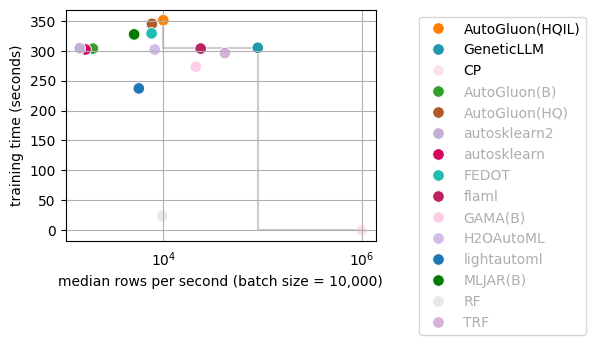

In [14]:
# pyplot.locator_params(nbins=4)
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MaxNLocator


for name_time in strings_by_time:
    this_framework = results[results['framework'].str.contains(name_time) | results['framework'].isin(extra_frameworks)]
    this_framework['framework'] = this_framework['framework'].apply(lambda x: name_mapping.get(x, x))
    this_framework = this_framework[~this_framework['framework'].str.contains('Naive')]
    this_framework = this_framework[~this_framework['framework'].str.contains('TPOT')]

    exclude = ["CP_60min", "RF_60min", "TRF_60min"]
    data = this_framework
    data = impute_missing_results(data, with_results_from="CP_60min")
    data = data[["framework", "task", "constraint", "metric", "result", "infer_batch_size_file_10000", "training_duration"]].groupby(["framework", "task", "constraint", "metric"], as_index=False).mean()

    current_frameworks = data.framework.unique()
    common_elements = [element for element in list_order if element in current_frameworks]

    data = add_rescale(data, lower="RF_60min")    
    data = data[~data["framework"].isin(exclude)]
    data['framework'] = data['framework'].str.replace(name_time, '')

    current_frameworks = data.framework.unique()
    common_elements = [element for element in list_order if element in current_frameworks]
    
    # data = data.groupby(["framework", "constraint", "metric"])[["infer_batch_size_file_10000", "training_duration"]].median()
    data = data.groupby(["framework", "constraint"])[["infer_batch_size_file_10000", "training_duration"]].median()

    data["row_per_s"] = 10_000. / data["infer_batch_size_file_10000"]
    color_map = {k: v for k, v in FRAMEWORK_TO_COLOR.items() if k not in exclude}

    ###
    frameworks_to_keep_legend = []
    pareto_efficient = calculate_pareto(data["row_per_s"], data["training_duration"])
    pareto_efficient_list = [x for x, y in pareto_efficient]
    pareto_not_efficient_list = []
    for framework in FRAMEWORK_TO_COLOR.keys():
        if framework in data.index.get_level_values('framework').unique():
            is_efficient = any(row_per_s_value in pareto_efficient_list for row_per_s_value in data.loc[framework, "row_per_s"])
            if is_efficient:
                frameworks_to_keep_legend.append(framework)
            else:
                pareto_not_efficient_list.append(framework)  # Grey color for inefficient methods

    # Create a dictionary to map frameworks to their corresponding row_per_s values
    framework_to_row_per_s = {framework: data.loc[framework, "row_per_s"].values[0] for framework in frameworks_to_keep_legend}
    
    # Sort frameworks_to_keep_legend based on the row_per_s values
    frameworks_to_keep_legend.sort(key=lambda framework: framework_to_row_per_s[framework])
    common_elements = frameworks_to_keep_legend + pareto_not_efficient_list# sorted
    ###

    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax = seaborn.scatterplot(
        data, 
        x="row_per_s", 
        y="training_duration", 
        hue="framework",
        palette=color_map,
        s=70,  # marker size
        hue_order=common_elements,
        ax=ax,
    )
    # pareto_performance_inference(data, x="row_per_s", y="training_duration", ax=ax)
    plot_pareto(data, x="row_per_s", y="training_duration", ax=ax)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.set_xscale('log')
    ax.set_xlabel('median rows per second (batch size = 10,000)')
    ax.set_ylabel('training time (seconds)')
    ax.grid(True)  # Add grid here

    pareto_efficient = calculate_pareto(data["row_per_s"], data["training_duration"])
    pareto_efficient_list = [x for x, y in pareto_efficient]
    pareto_efficient_list = sorted([x for x, y in pareto_efficient])
    first_last_pareto = [pareto_efficient_list[0], pareto_efficient_list[-1]]
    selected_ticks = first_last_pareto
    selected_labels = first_last_pareto
    selected_labels = [f"$10^{{{int(np.log10(tick))}}}$" for tick in selected_ticks]

    # Set the selected x-ticks and labels
    ax.set_xticks(selected_ticks)
    ax.set_xticklabels(selected_labels)
    
    # Ensure the tick parameters are set correctly
    ax.tick_params(axis='x', which='major', bottom=False, top=False, labelbottom=True)
    ###
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.7, 1))
    
    # Change the color of the first three labels to red
    for text in legend.get_texts()[len(frameworks_to_keep_legend):]:
        text.set_color('#aeaeae')
    ###
    # ax.set_title(f"{name_fr}-{ttype}")
    # Define the file path for the PNG file
    
    with PdfPages(FIGURE_DIRECTORY / "pareto_training_inference" / f"training_inference{name_time}_all.pdf") as f:
        f.savefig(fig, bbox_inches="tight")

    file_path = FIGURE_DIRECTORY / "pareto_training_inference" / f"training_inference{name_time}_all.png"
    # Save the figure as a PNG file
    fig.savefig(file_path, bbox_inches="tight", dpi=1000)
    
    plt.show()
    plt.close(fig)

### By task type

Processing type: binary


C:\Users\20210595\AppData\Local\Temp\ipykernel_34800\2923568225.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_framework['framework'] = this_framework['framework'].apply(lambda x: name_mapping.get(x, x))


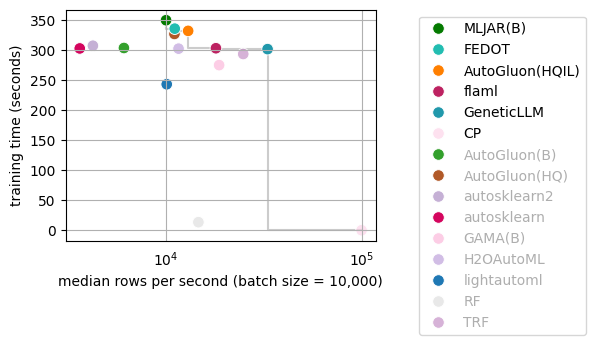

Processing type: multiclass


C:\Users\20210595\AppData\Local\Temp\ipykernel_34800\2923568225.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_framework['framework'] = this_framework['framework'].apply(lambda x: name_mapping.get(x, x))


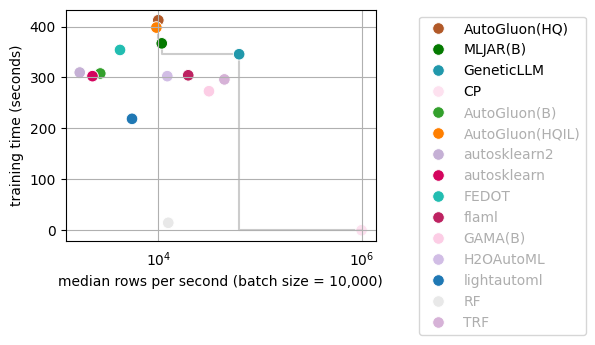

Processing type: regression


C:\Users\20210595\AppData\Local\Temp\ipykernel_34800\2923568225.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_framework['framework'] = this_framework['framework'].apply(lambda x: name_mapping.get(x, x))


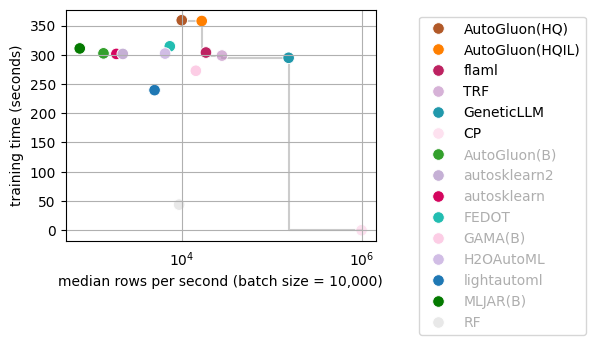

In [18]:
# Group the DataFrame by 'type'
grouped_by_type = results.groupby('type')

# Iterate over each group
for type_name, group in grouped_by_type:
    print(f"Processing type: {type_name}")
    
    for name_time in strings_by_time:
        this_framework = group[group['framework'].str.contains(name_time) | group['framework'].isin(extra_frameworks)]
    
        this_framework['framework'] = this_framework['framework'].apply(lambda x: name_mapping.get(x, x))
        this_framework = this_framework[~this_framework['framework'].str.contains('Naive')]
        this_framework = this_framework[~this_framework['framework'].str.contains('TPOT')]
    
        exclude = ["CP_60min", "RF_60min", "TRF_60min"]
        data = this_framework
        data = impute_missing_results(data, with_results_from="CP_60min")
        data = data[["framework", "task", "constraint", "metric", "result", "infer_batch_size_file_10000", "training_duration"]].groupby(["framework", "task", "constraint", "metric"], as_index=False).mean()
    
        current_frameworks = data.framework.unique()
        common_elements = [element for element in list_order if element in current_frameworks]
    
        data = add_rescale(data, lower="RF_60min")    
        data = data[~data["framework"].isin(exclude)]
        data['framework'] = data['framework'].str.replace(name_time, '')
    
        current_frameworks = data.framework.unique()
        common_elements = [element for element in list_order if element in current_frameworks]
        
        # data = data.groupby(["framework", "constraint", "metric"])[["infer_batch_size_file_10000", "training_duration"]].median()
        data = data.groupby(["framework", "constraint"])[["infer_batch_size_file_10000", "training_duration"]].median()
    
        data["row_per_s"] = 10_000. / data["infer_batch_size_file_10000"]
        color_map = {k: v for k, v in FRAMEWORK_TO_COLOR.items() if k not in exclude}
    
        ###
        frameworks_to_keep_legend = []
        pareto_efficient = calculate_pareto(data["row_per_s"], data["training_duration"])
        pareto_efficient_list = [x for x, y in pareto_efficient]
        pareto_not_efficient_list = []
        for framework in FRAMEWORK_TO_COLOR.keys():
            if framework in data.index.get_level_values('framework').unique():
                is_efficient = any(row_per_s_value in pareto_efficient_list for row_per_s_value in data.loc[framework, "row_per_s"])
                if is_efficient:
                    frameworks_to_keep_legend.append(framework)
                else:
                    pareto_not_efficient_list.append(framework)  # Grey color for inefficient methods
    
        # Create a dictionary to map frameworks to their corresponding row_per_s values
        framework_to_row_per_s = {framework: data.loc[framework, "row_per_s"].values[0] for framework in frameworks_to_keep_legend}
        
        # Sort frameworks_to_keep_legend based on the row_per_s values
        frameworks_to_keep_legend.sort(key=lambda framework: framework_to_row_per_s[framework])
        common_elements = frameworks_to_keep_legend + pareto_not_efficient_list# sorted
        ###
    
        fig, ax = plt.subplots(1, 1, figsize=(4, 3))
        ax = seaborn.scatterplot(
            data, 
            x="row_per_s", 
            y="training_duration", 
            hue="framework",
            palette=color_map,
            s=70,  # marker size
            hue_order=common_elements,
            ax=ax,
        )
        # pareto_performance_inference(data, x="row_per_s", y="training_duration", ax=ax)
        plot_pareto(data, x="row_per_s", y="training_duration", ax=ax)
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax.set_xscale('log')
        ax.set_xlabel('median rows per second (batch size = 10,000)')
        ax.set_ylabel('training time (seconds)')
        ax.grid(True)  # Add grid here
    
        pareto_efficient = calculate_pareto(data["row_per_s"], data["training_duration"])
        pareto_efficient_list = [x for x, y in pareto_efficient]
        pareto_efficient_list = sorted([x for x, y in pareto_efficient])
        first_last_pareto = [pareto_efficient_list[0], pareto_efficient_list[-1]]
        selected_ticks = first_last_pareto
        selected_labels = first_last_pareto
        selected_labels = [f"$10^{{{int(np.log10(tick))}}}$" for tick in selected_ticks]
    
        # Set the selected x-ticks and labels
        ax.set_xticks(selected_ticks)
        ax.set_xticklabels(selected_labels)
        
        # Ensure the tick parameters are set correctly
        ax.tick_params(axis='x', which='major', bottom=False, top=False, labelbottom=True)
        ###
        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.7, 1))
        
        # Change the color of the first three labels to red
        for text in legend.get_texts()[len(frameworks_to_keep_legend):]:
            text.set_color('#aeaeae')
        ###
        # ax.set_title(f"{name_fr}-{ttype}")
        # Define the file path for the PNG file
        
        with PdfPages(FIGURE_DIRECTORY / "pareto_training_inference" / f"training_inference{name_time}_{type_name}.pdf") as f:
            f.savefig(fig, bbox_inches="tight")
    
        file_path = FIGURE_DIRECTORY / "pareto_training_inference" / f"training_inference{name_time}_{type_name}.png"
        # Save the figure as a PNG file
        fig.savefig(file_path, bbox_inches="tight", dpi=1000)
        
        plt.show()
        plt.close(fig)